In [1]:
import numpy as np, matplotlib.pyplot as plt, os
import tools21cm as t2c, py21cmfast as p21c
from py21cmfast import plotting
import random, zipfile
from astropy.cosmology import FlatLambdaCDM
from tqdm import tqdm

import matplotlib.gridspec as gridspec

from itertools import permutations
from datetime import datetime

# create seed for 21cmFast
str_seed = [var for var in datetime.now().strftime('%d%H%M%S')]
np.random.shuffle(str_seed)
seed = int(''.join(str_seed))

#outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/test_predict/'
outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/layers_output/'

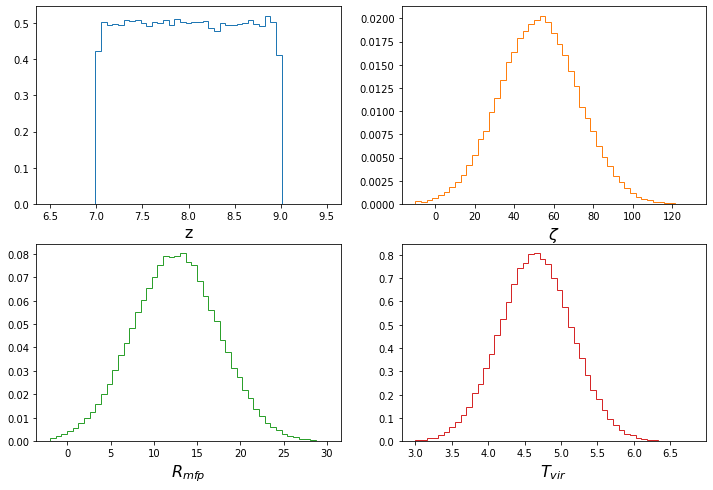

(None, None, None)

<Figure size 432x288 with 0 Axes>

In [2]:
redshift = np.random.uniform(7, 9, 100000)
eff_fact = [random.gauss(52.5, 20.) for i in range(100000)]
Rmfp = [random.gauss(12.5, 5.) for i in range(100000)]
Tvir = [random.gauss(4.65, 0.5) for i in range(100000)]

fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs[0,0].hist(redshift, np.linspace(6.5,9.5), density=True, histtype='step', color='tab:blue');
axs[0,1].hist(eff_fact, np.linspace(-10,130), density=True, histtype='step', color='tab:orange');
axs[1,0].hist(Rmfp, np.linspace(-2,30), density=True, histtype='step', color='tab:green');
axs[1,1].hist(Tvir, np.linspace(3,6.8), density=True, histtype='step', color='tab:red');
axs[0,0].set_xlabel(r'z', size=16)
axs[0,1].set_xlabel(r'$\zeta$', size=16)
axs[1,0].set_xlabel(r'$R_{mfp}$', size=16)
axs[1,1].set_xlabel(r'$T_{vir}$', size=16);
plt.savefig(outpath+'astro_params_stat.png', bbox_inches='tight'), plt.show(), plt.clf()

## Create coeval cubes
Here we create the 21cmFast cube outputs 

In [2]:
from myutils.utils import OrderNdimArray

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/pred_tobs1000/'
indexes, redshift, xn_sim, phicoef_seg, phicoef_seg_err, phicoef_sp, xfrac = OrderNdimArray(np.loadtxt(PATH_MODEL+'astro_data.txt', unpack=True, usecols=(0,1,5,6,7,8,9)), 1)
data = np.loadtxt(PATH_MODEL+'astro_data.txt', unpack=True, usecols=(0,1,5,6,7,8,9))

zc = (redshift < 7.5) + (redshift > 8.3)
c1 = (xfrac<=0.25)*(xfrac>=0.15)*zc
c2 = (xfrac<=0.55)*(xfrac>=0.45)*zc
c3 = (xfrac<=0.75)*(xfrac>=0.85)*zc
new_idx = indexes[c1+c2+c3].astype(int)
print(new_idx.size)
print(new_idx)
print(data[:,new_idx].shape)
index = new_idx[31]
print(index)
np.savetxt(outpath+'astro_data.txt', data[:,new_idx].T, fmt='%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f', header='i\tz\teff_f\tRmfp\tTvir\tx_n\tphi_ML\tphi_err\tphi_SP\txn_mask\txn_seg\txn_err\txn_sp')


32
[297  14 243 158 188  96 267 111 276  39 232 159 269 108 126 221 282 283
  86  50  58 178 100 155  76 292 135 250 213  72 117  99]
(7, 32)
99


In [2]:
sim = '21cmFAST'
index = 228

if(sim == '21cmFAST'):
    #xHI = np.array([0.2, 0.5, 0.8])
    #redshift = np.array([7.310, 8.032, 8.720])
    z = 8.032
    zeta = 39.204
    Rmfp = 12.861
    Tvir = 4.539

    params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
    #params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':128}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    a_params = {'HII_EFF_FACTOR':zeta, 'R_BUBBLE_MAX':Rmfp, 'ION_Tvir_MIN':Tvir}

    ic = p21c.initial_conditions(user_params=params, cosmo_params=c_params, random_seed=2021)
    cube = p21c.run_coeval(redshift=z, init_box=ic, astro_params=a_params, zprime_step_factor=1.05)
    
    dT = cube.brightness_temp
    xH = cube.xH_box
    
    name = ''
    
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, np.mean(cube.xH_box), zeta, Rmfp, Tvir))
elif(sim == 'tobs'):
    PATH_INPUT = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_061020/tobs900.zip'
    PATH_IN_ZIP = PATH_INPUT[PATH_INPUT.rfind('/')+1:-4]+'/'
    PATH_UNZIP = PATH_INPUT[:PATH_INPUT.rfind('/')+1]

    params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    
    with zipfile.ZipFile(PATH_INPUT, 'r') as myzip:
        astr_data = np.loadtxt(myzip.open('%sastro_params.txt' %PATH_IN_ZIP))[index]
        
        f = myzip.extract(member='%simage_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index), path=PATH_UNZIP)
        dT3 = t2c.read_cbin(f) 
        f = myzip.extract(member='%smask_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index), path=PATH_UNZIP)
        mask_xn = t2c.read_cbin(f) 
        os.system('rm -r %s/' %(PATH_UNZIP+PATH_IN_ZIP))
        #print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, 1-np.mean(xi), zeta, Rmfp, Tvir))
    
    z, zeta, Rmfp, Tvir, xn = astr_data[1:]
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, xn, zeta, Rmfp, Tvir))
    print('xn_mask = %.3f' %np.mean(mask_xn))
    name = '_i%d' %index
    
elif(sim == 'C2Ray'):
    zeta = 0.0
    Rmfp = 0.0
    Tvir = 0.0
    z = 8.064
    
    pathLB = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/244Mpc_f2_8.2pS_500/'

    #params = {'HII_DIM':128, 'BOX_LEN':128*2.057}
    params = {'HII_DIM':128, 'BOX_LEN':128*2.099827883}
    c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
    my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

    #dT = t2c.read_cbin('%sdTb_cbin_z%.3f.dat' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    n_all = t2c.read_cbin('%s%.3fn_all_r2.09.bin' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    xi = t2c.read_cbin('%sxfrac3d_%.3f_r2.09.bin' %(pathLB, z))[0:params['HII_DIM'],0:params['HII_DIM'],0:params['HII_DIM']]
    
    dT = t2c.calc_dt(xfrac=xi, dens=n_all, z=z)
    xH = 1-xi
    
    name = '_244Mpc_z%.3f_r2.09' %z
    
    print('z = %.3f  x_n = %.3f  zeta = %.3f  R_mfp = %.3f  T_vir = %.3f' %(z, 1-np.mean(xi), zeta, Rmfp, Tvir))

cosmo = FlatLambdaCDM(H0=70., Ob0=c_params['OMb'], Om0=c_params['OMm'])

z = 8.032  x_n = 0.482  zeta = 39.204  R_mfp = 12.861  T_vir = 4.539


## Differential Brightness
Calculate the differential brightness temperature $\delta T_{b}$ assuming $T_S\gg T_{CMB}$ (heating approximation or saturated limit)

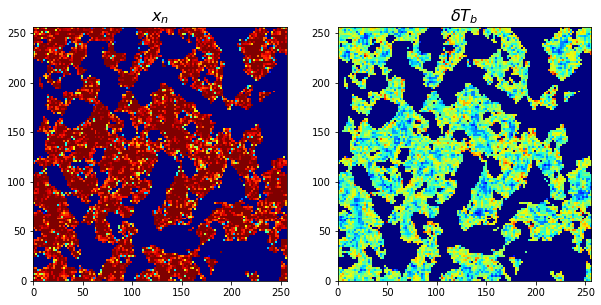

In [3]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121)
plt.title('$x_n$', size=16)
plt.imshow(xH[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.subplot(122)
plt.title(r'$\delta T_b$', size=16)
plt.imshow(dT[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')

## Plot spherically averaged power spectrum

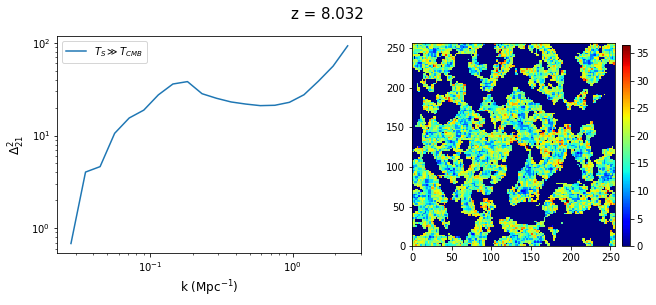

In [4]:
ps, ks, n_modes = t2c.power_spectrum_1d(dT, kbins=20, box_dims=params['BOX_LEN'],
                                        return_n_modes=True, binning='log')

fig = plt.figure(figsize=(10, 4))
fig.suptitle('z = %.3f' %z, fontsize=15)
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1.5, 1])
ax0 = fig.add_subplot(gs[0,0])
ax0.loglog(ks, ps*ks**3/2/np.pi**2, 'tab:blue', label=r'$T_S \gg T_{CMB}$')
ax0.set_xlabel('k (Mpc$^{-1}$)', fontsize=12), ax0.set_ylabel('$\Delta^2_\mathrm{21}$', fontsize=12)
ax1 = fig.add_subplot(gs[0,1])
im = ax1.imshow(dT[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
ax0.legend()
plt.colorbar(im, ax=ax1, cax=fig.add_axes([0.91, 0.15, 0.01, 0.7]))

## Telescope noise calculation. 
Calculation of the uv-coverage. See https://arxiv.org/abs/1607.02779 & https://arxiv.org/abs/1801.06550 

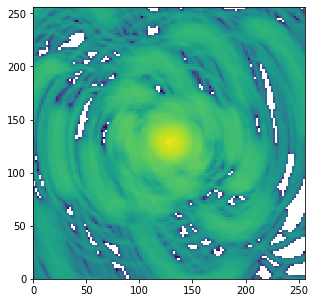

In [6]:
import pickle

uvfile = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/uvmap_128_z7-20.pkl'
if not (os.path.exists(uvfile)):
    print('uv-map pickle not found')
else:
    uvs = pickle.load(open(uvfile, 'rb'))

uv = uvs['%.3f' %z]
Nant = uvs['Nant']

plt.figure(figsize=(15, 5))
plt.imshow(np.log10(np.fft.fftshift(uv)), origin='lower', extent=my_ext)

### Creating the noise cube

In [7]:
tobs = 1000

np.random.seed(seed)
noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                   total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                   N_ant=Nant, verbose=True, fft_wrap=False)


Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 262.73it/s]

...noise cube created.


Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 305.31it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 371.15it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 365.86it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 369.31it/s]


...noise cube created.
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 366.21it/s]


...noise cube created.


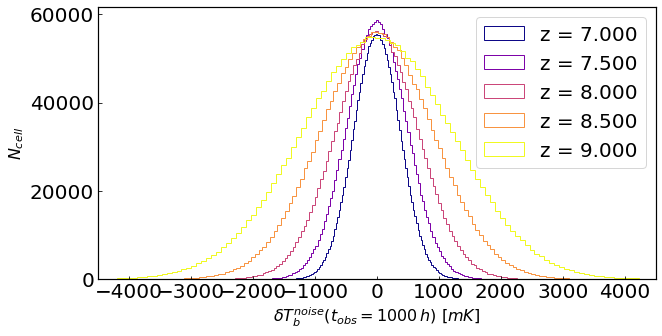

(None, None, None)

<Figure size 720x360 with 0 Axes>

In [33]:
import pickle, matplotlib

redshift = np.arange(7.000, 9.001, 0.001)

norm = matplotlib.colors.Normalize(vmin=redshift.min(), vmax=redshift.max(), clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
plt.figure(figsize=(10,5))
for zn in [7.0, 7.5, 8.0, 8.5, 9.0]:
    uvfile = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/uvmap_128_z7-20.pkl'
    if not (os.path.exists(uvfile)):
        print('uv-map pickle not found')
    else:
        uvs = pickle.load(open(uvfile, 'rb'))

    uv = uvs['%.3f' %zn]
    Nant = uvs['Nant']
    tobs = 1000
    np.random.seed(seed)
    noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], zn,
                                       depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                       obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                       total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                       N_ant=Nant, verbose=True, fft_wrap=False)


    plt.hist(noise_cube.flatten(), bins=150, histtype='step', color=mapper.to_rgba(zn), label='z = %.3f' %zn)

plt.xlim(-4500,4500)
plt.ylabel(r'$N_{cell}$', size=16)
plt.xlabel(r'$\delta T_b^{noise}(t_{obs}=1000\,h)$ $[mK]$', size=16)
plt.legend()
plt.savefig('%snoise%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

In [7]:
dT1 = t2c.subtract_mean_signal(dT, los_axis=2)
dT2 = dT1 + noise_cube

# Smooth the data to resolution corresponding to maximum baseline of 2 km
dT3 = t2c.smooth_coeval(dT2, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)

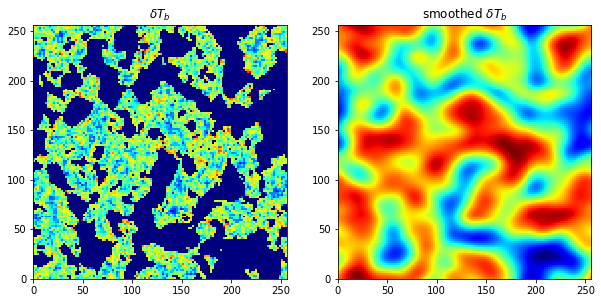

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121)
plt.title('$\delta T_b$')
plt.imshow(dT1[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.subplot(122)
plt.title('smoothed $\delta T_b$')
plt.imshow(dT3[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')

sim x_n = 0.4825
smt x_n = 0.4825
mask x_n = 0.5001


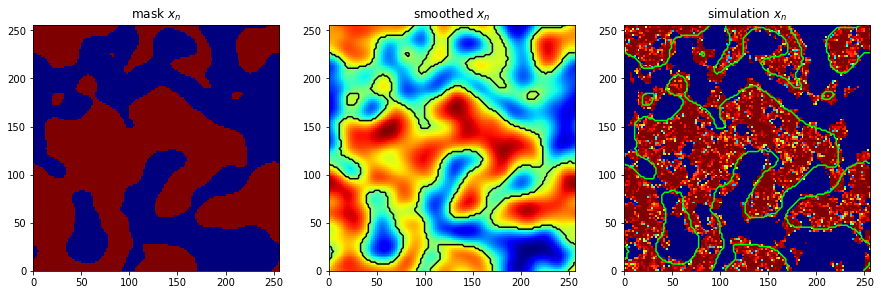

In [9]:
smt_xn = t2c.smooth_coeval(xH, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)
mask_xn = smt_xn>0.5

print('sim x_n = %.4f' %np.mean(xH))
print('smt x_n = %.4f' %np.mean(smt_xn))
print('mask x_n = %.4f' %np.mean(mask_xn))

plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(131)
plt.title('mask $x_n$')
plt.imshow(mask_xn[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
plt.subplot(132)
plt.title('smoothed $x_n$')
plt.contour(mask_xn[:,:,params['HII_DIM']//2], colors='k', levels=[0.5], extent=my_ext)
plt.imshow(smt_xn[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
plt.subplot(133)
plt.title('simulation $x_n$')
plt.contour(mask_xn[:,:,params['HII_DIM']//2], colors='lime', levels=[0.5], extent=my_ext)
plt.imshow(xH[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)

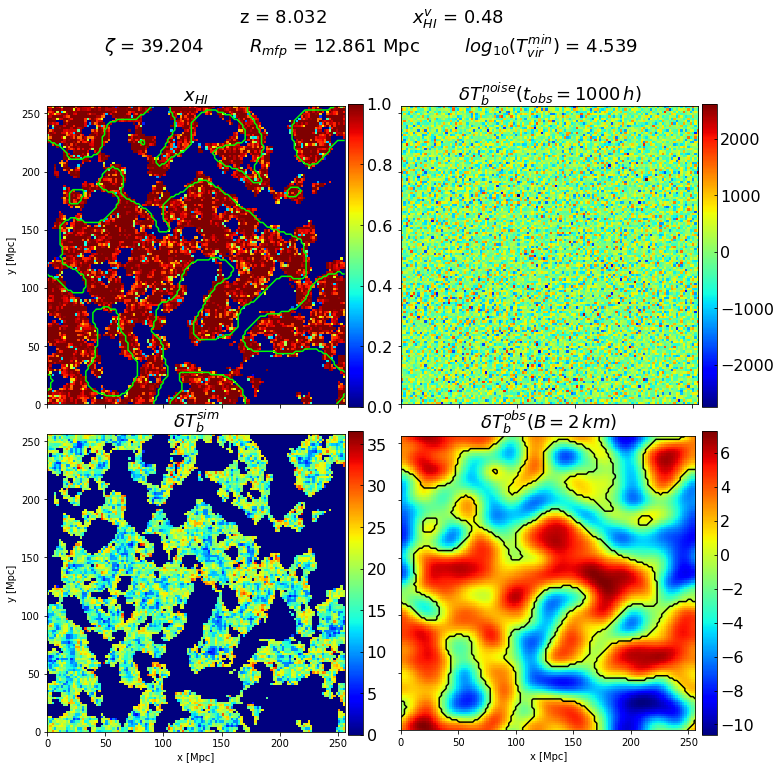

(None, None, None)

<Figure size 1080x360 with 0 Axes>

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))
for ax in axs.flat: ax.label_outer()

fig.suptitle('z = %.3f\t\t$x^v_{HI}$ = %.2f\n$\zeta$ = %.3f        $R_{mfp}$ = %.3f Mpc        $log_{10}(T_{vir}^{min})$ = %.3f' %(z, np.mean(xH), zeta, Rmfp, Tvir), fontsize=18)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 16

axs[0,0].set_title('$x_{HI}$', size=18)
axs[0,0].contour(mask_xn[:,:,params['HII_DIM']//2], colors='lime', levels=[0.5], extent=my_ext)
im = axs[0,0].imshow(xH[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, ax=axs[0,0], pad=0.01, fraction=0.048)
axs[0,0].set_ylabel('y [Mpc]');

axs[0,1].set_title('$\delta T^{noise}_b(t_{obs}=%d\,h)$' %tobs, size=18)
im = axs[0,1].imshow(dT2[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, ax=axs[0,1], pad=0.01, fraction=0.048)

axs[1,0].set_title('$\delta T^{sim}_b$', size=18)
im = axs[1,0].imshow(dT[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
axs[1,0].set_xlabel('x [Mpc]'), axs[1,0].set_ylabel('y [Mpc]');
fig.colorbar(im, ax=axs[1,0], pad=0.01, fraction=0.048)

axs[1,1].set_title('$\delta T^{obs}_b(B=2\,km)$', size=18)
im = axs[1,1].imshow(dT3[:,:,params['HII_DIM']//2], origin='lower', cmap='jet', extent=my_ext)
axs[1,1].contour(mask_xn[:,:,params['HII_DIM']//2], colors='k', levels=[0.5], extent=my_ext)
axs[1,1].set_xlabel('x [Mpc]')
fig.colorbar(im, ax=axs[1,1], pad=0.02, fraction=0.048)

plt.subplots_adjust(hspace=0.01, wspace=0.12)

plt.savefig('%scube21cm%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

## Load SegUnet best model

In [11]:
import matplotlib.pyplot as plt, numpy as np
import tools21cm as t2c
from matplotlib import gridspec

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.linewidth'] = 1.2
ls = 22

In [10]:
from tensorflow.keras.models import load_model
from utils_network.metrics import iou, iou_loss, dice_coef, dice_coef_loss, balanced_cross_entropy, phi_coef
from config.net_config import NetworkConfig

def LoadSegUnetModel(cfile):
    avail_metrics = {'binary_accuracy':'binary_accuracy', 'iou':iou, 'dice_coef':dice_coef, 'iou_loss':iou_loss, 'dice_coef_loss':dice_coef_loss, 'phi_coef':phi_coef, 'mse':'mse', 'mae':'mae', 'binary_crossentropy':'binary_crossentropy', 'balanced_cross_entropy':balanced_cross_entropy}
    conf = NetworkConfig(conf_file)

    PATH_OUT = conf.resume_path
    MODEL_EPOCH = conf.best_epoch
    METRICS = [avail_metrics[m] for m in np.append(conf.loss, conf.metrics)]
    cb = {func.__name__:func for func in METRICS if not isinstance(func, str)}
    model_loaded = load_model('%smodel-sem21cm_ep%d.h5' %(PATH_OUT+'checkpoints/', MODEL_EPOCH), custom_objects=cb)
    
    print(' Loaded model:\n %smodel-sem21cm_ep%d.h5' %(conf.resume_path, MODEL_EPOCH))
    return model_loaded

Using TensorFlow backend.


In [11]:
# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/tests/runs/'
#conf_file += 'net2D_201020.ini'
#conf_file += 'net2D_161020.ini'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/model-sem21cm_ep56.h5


## Calculate Prediction

In [14]:
# SegUnet
from utils_network.prediction import SegUnet21cmPredict
from utils.other_utils import RescaleData

"""
# a and b values are based on the training dataset
dT3 = RescaleData(arr=dT3, a=-11, b=11)
"""

X_tta = SegUnet21cmPredict(unet=model, x=dT3, TTA=False)
X_seg = np.round(np.mean(X_tta, axis=0))

100%|██████████| 1/1 [00:18<00:00, 18.41s/it]


In [15]:
# super-pixel
labels = t2c.slic_cube(dT3.astype(dtype='float64'), n_segments=50000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(dT3, labels)
X_sp = 1-t2c.stitch_superpixels(dT3, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 74959 segments


In [16]:
from sklearn.metrics import matthews_corrcoef

phicoef_tta = np.zeros(X_tta.shape[0])
xn_tta = np.zeros(X_tta.shape[0])
for i in tqdm(range(len(X_tta))):
    x = X_tta[i]
    
    xn_tta[i] = np.mean(np.round(x))
    phicoef_tta[i] = matthews_corrcoef(mask_xn.flatten(), np.round(x).flatten())

xn_err = np.std(xn_tta)
phicoef_err = np.std(phicoef_tta)

phicoef_seg = matthews_corrcoef(mask_xn.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(mask_xn.flatten(), X_sp.flatten())

100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


In [17]:
print('x_n = %.4f\t\t(Mask)' %np.mean(mask_xn))
print('x_n = %.4f +/- %.4f\t(SegUnet)' %(np.mean(X_seg), xn_err))
print('x_n = %.4f\t\t(Superpixel)\n' %np.mean(X_sp))

print('phi_coef = %.3f +/- %.3f\t(SegUnet)' %(phicoef_seg, phicoef_err))
print('phi_coef = %.3f\t\t(Superpixel)' %phicoef_sp)

x_n = 0.5001		(Mask)
x_n = 0.5014 +/- 0.0037	(SegUnet)
x_n = 0.5765		(Superpixel)

phi_coef = 0.925 +/- 0.004	(SegUnet)
phi_coef = 0.836		(Superpixel)


In [45]:
x = np.array(X_seg.flatten(), dtype=bool)
m = np.array(mask_xn.flatten(), dtype=bool)

TP = np.sum(x*m)
TN = np.sum((1-x)*(1-m))
FP = np.sum(x*(1-m))
FN = np.sum((1-x)*m)

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
iou = TP/(TP+FP+FN)

print('Acc = %.3f\tPrec = %.3f\tRec = %.3f\tIoU = %.3f'%(acc, prec, rec, iou))
x = np.array(X_sp.flatten(), dtype=bool)
m = np.array(mask_xn.flatten(), dtype=bool)

TP = np.sum(x*m)
TN = np.sum((1-x)*(1-m))
FP = np.sum(x*(1-m))
FN = np.sum((1-x)*m)

acc = (TP+TN)/(TP+TN+FP+FN)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
iou = TP/(TP+FP+FN)

print('Acc = %.3f\tPrec = %.3f\tRec = %.3f\tIoU = %.3f'%(acc, prec, rec, iou))

Acc = 0.962	Prec = 0.964	Rec = 0.961	IoU = 0.927
Acc = 0.913	Prec = 0.988	Rec = 0.837	IoU = 0.828


In [ ]:
#t2c.save_cbin('%simage_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index))
#t2c.save_cbin('%smask_21cm_i%d.bin' %(PATH_IN_ZIP+'data/', index))
#print(index)

## SegUnet Visual comparison

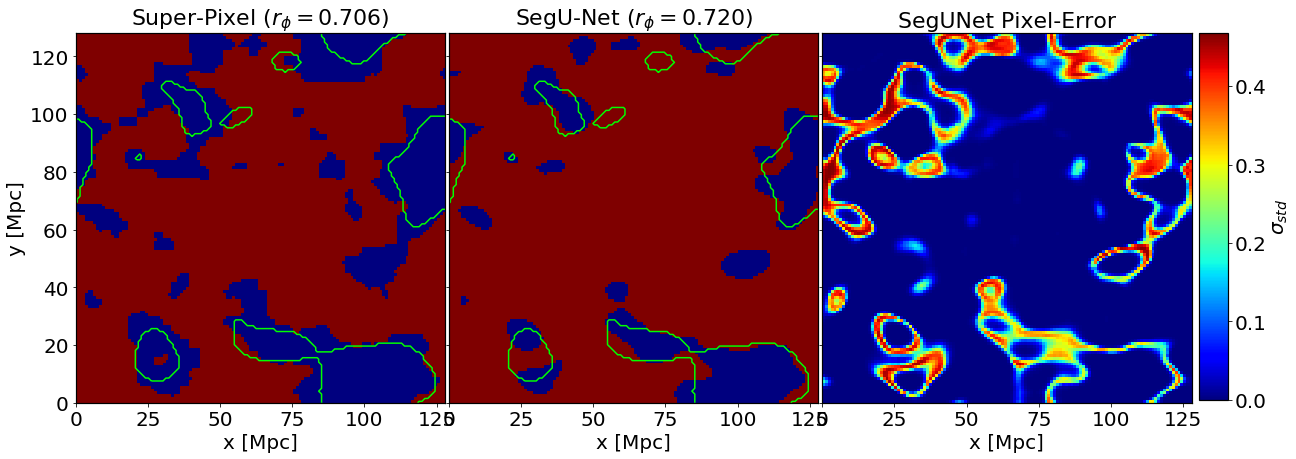

<Figure size 1440x720 with 0 Axes>

In [20]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]

idx = params['HII_DIM']//2

X_seg_err = np.std(X_tta, axis=0)

fig, axs = plt.subplots(figsize=(20,10), ncols=3, sharey=True, sharex=True)
(ax0, ax1, ax2) = axs
ax0.set_title('Super-Pixel ($r_{\phi}=%.3f$)' %phicoef_sp, size=ls)
ax0.imshow(X_sp[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
ax0.contour(mask_xn[:,:,idx], colors='lime', levels=[0.5], extent=my_ext)
ax0.set_xlabel('x [Mpc]'), ax0.set_ylabel('y [Mpc]')

ax1.set_title('SegU-Net ($r_{\phi}=%.3f$)' %phicoef_seg, size=ls)
ax1.imshow(X_seg[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
ax1.contour(mask_xn[:,:,idx], colors='lime', levels=[0.5], extent=my_ext)
ax1.set_xlabel('x [Mpc]')

ax2.set_title('SegUNet Pixel-Error', size=ls)
im = plt.imshow(X_seg_err[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, label=r'$\sigma_{std}$', ax=ax2, pad=0.02, cax=fig.add_axes([0.905, 0.25, 0.02, 0.51]))
ax2.set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in axs.flat: ax.label_outer()

plt.savefig('%svisual_comparison%s.png' %(outpath, name), bbox_inches='tight')

plt.show()
plt.clf()

## Betti Number 

In [33]:
betti_true = [t2c.betti0(data=mask_xn), t2c.betti1(data=mask_xn), t2c.betti2(data=mask_xn)]
betti_seg = [t2c.betti0(data=X_seg), t2c.betti1(data=X_seg), t2c.betti2(data=X_seg)]
betti_sp = [t2c.betti0(data=X_sp), t2c.betti1(data=X_sp), t2c.betti2(data=X_sp)]

"""
b0_tta = np.zeros(X_tta.shape[0])
b1_tta = np.zeros(X_tta.shape[0])
b2_tta = np.zeros(X_tta.shape[0])

for i_x in tqdm(range(X_tta.shape[0])):
    x = X_tta[i_x] 
    b0_tta[i_x] = t2c.betti0(data=x)
    b1_tta[i_x] = t2c.betti1(data=x)
    b2_tta[i_x] = t2c.betti2(data=x)
""";   

In [34]:
print(betti_true)
print(betti_seg)
print(betti_sp)

[12, 124.0, 6]
[7, 128.0, 10]
[4, 99.0, 7]


## BSD - MFP

In [ ]:
name = 'xn%.1f_xHII' %np.mean(mask_xn)
mfp_pred_ml = t2c.bubble_stats.mfp(1-X_seg, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
mfp_pred_sp = t2c.bubble_stats.mfp(1-X_sp, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
mfp_true = t2c.bubble_stats.mfp(1-mask_xn, xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)  

mfp_tta = np.zeros((X_tta.shape[0], 2, 128))
for i in tqdm(range(0, X_tta.shape[0])):
    mfp_pred_ml1, mfp_pred_ml2 = t2c.bubble_stats.mfp(np.round(1-X_tta[i]), xth=0.5, boxsize=params['BOX_LEN'], iterations=2000000, verbose=False, upper_lim=False, bins=None, r_min=None, r_max=None)
    mfp_tta[i,0] = mfp_pred_ml1
    mfp_tta[i,1] = mfp_pred_ml2

In [ ]:
from scipy import integrate

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

compare_ml = (mfp_pred_ml[1]/mfp_true[1])
compare_ml_tta = (mfp_tta[:,1,:]/mfp_true[1])
compare_sp = (mfp_pred_sp[1]/mfp_true[1])

rC_true = integrate.simps(mfp_true[1], mfp_true[0])
rC_seg = integrate.simps(mfp_pred_ml[1], mfp_pred_ml[0])
rC_sp = integrate.simps(mfp_pred_sp[1], mfp_pred_sp[0])


# PLOTS
fig, ax0 = plt.subplots(figsize=(12, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.8]) # set height ratios for sublots

# THE FIRST SUBPLOT
ax0 = plt.subplot(gs[0])
#ax0.set_title('$z=%.3f$\t$x_n=%.3f$\t$r_{\phi}=%.3f$' %(z, np.mean(xH), phicoef_seg), fontsize=ls)
ax0.fill_between(mfp_pred_ml[0], np.min(mfp_tta[:,1,:], axis=0), np.max(mfp_tta[:,1,:], axis=0), color='tab:blue', alpha=0.2)
ax0.loglog(mfp_pred_ml[0], mfp_pred_ml[1], '-', color='tab:blue', label=r'SegUNet: $r_{\phi}=%.3f$' %phicoef_seg, lw=2)
ax0.loglog(mfp_pred_sp[0], mfp_pred_sp[1], '-', color='tab:orange', label=r'Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sp, lw=2)
ax0.loglog(mfp_true[0], mfp_true[1], 'k--', label='Ground true', lw=2)
ax0.legend(loc='best', borderpad=0.5)
ax0.tick_params(axis='both', length=7, width=1.2)
ax0.tick_params(axis='both', which='minor', length=5, width=1.2)
ax0.set_ylabel('RdP/dR', size=18), ax0.set_xlabel('R (Mpc)')
ax0.axvline(x=rC_seg, color='tab:blue', linestyle='--')
ax0.axvline(x=rC_sp, color='tab:orange', linestyle='--')
ax0.axvline(x=rC_true, color='black', linestyle='--')

# THE SECOND SUBPLOT
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.loglog(mfp_true[0], compare_ml, '-', lw=2)
ax1.loglog(mfp_true[0], compare_sp, '-', lw=2)
ax1.loglog(mfp_true[0], np.ones_like(mfp_true[0]), 'k--', lw=2)
ax1.fill_between(mfp_true[0], np.min(compare_ml_tta, axis=0), np.max(compare_ml_tta, axis=0), color='tab:blue', alpha=0.2)
ax1.tick_params(axis='both', length=7, width=1.2, labelsize=15)
ax1.set_ylabel('difference (%)', size=15)
ax1.set_xlabel('R (Mpc)', size=18)
ax1.set_xlim(2,253)
# PLOT SETUP
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)
ax1.tick_params(which='minor', axis='both', length=5, width=1.2)
plt.savefig('%sbs_comparison%s.png' %(outpath, name), bbox_inches='tight')
#plt.savefig(outpath+'bs_comparison_i%d.png' %index, bbox_inches='tight')
plt.show(), plt.clf()

# Calculate the Power Spectra

In [37]:
ps_true, ks_true = t2c.power_spectrum_1d(mask_xn, kbins=20, box_dims=256, binning='log')
ps_pred_sp, ks_pred_sp = t2c.power_spectrum_1d(X_sp, kbins=20, box_dims=256, binning='log')
ps_pred_ml, ks_pred_ml = t2c.power_spectrum_1d(X_seg, kbins=20, box_dims=256, binning='log')

ps_tta = np.zeros((X_tta.shape[0],20))
for i in range(0,X_tta.shape[0]):
    ps_tta[i], ks_pred_ml = t2c.power_spectrum_1d(np.round(X_tta[i]), kbins=20, box_dims=256, binning='log')


In [38]:
compare_ml = 100*(ps_pred_ml/ps_true-1)
compare_ml_tta = 100*(ps_tta/ps_true-1)
compare_sp = 100*(ps_pred_sp/ps_true-1)

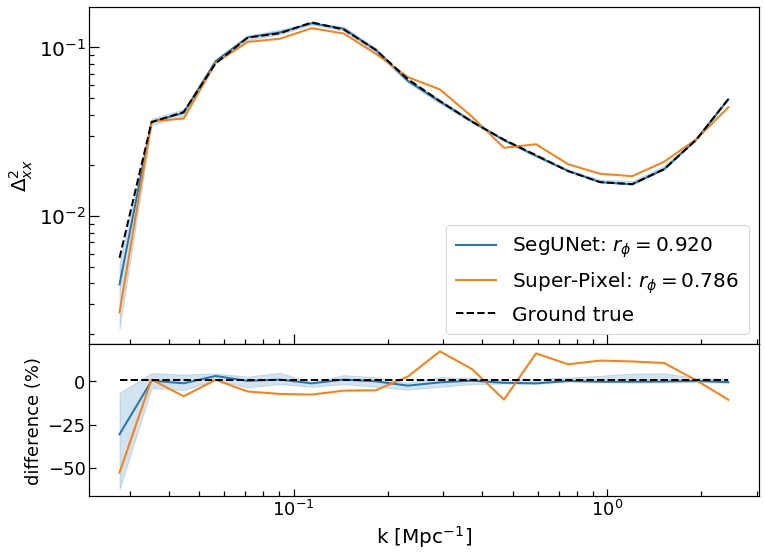

(None, None, None)

<Figure size 1440x720 with 0 Axes>

In [39]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

fig, ax = plt.subplots(figsize=(12, 9))
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.8])
ax0 = plt.subplot(gs[0])
#ax0.set_title('$z=%.3f$\t$x_n=%.3f$\t$r_{\phi}=%.3f$' %(z, np.mean(xH), phicoef_seg), fontsize=ls)
ax0.fill_between(ks_pred_ml, np.min(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), np.max(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), color='tab:blue', alpha=0.2)
ax0.loglog(ks_pred_ml, ps_pred_ml*ks_pred_ml**3/2/np.pi**2, '-', color='tab:blue', label=r'SegUNet: $r_{\phi}=%.3f$' %phicoef_seg, lw=2)
ax0.loglog(ks_pred_sp, ps_pred_sp*ks_pred_sp**3/2/np.pi**2, '-', color='tab:orange', label=r'Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sp, lw=2)
ax0.loglog(ks_true, ps_true*ks_true**3/2/np.pi**2, 'k--', label='Ground true', lw=2)
ax0.set_yscale('log')
# THE SECOND SUBPLOT 
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.semilogx(ks_true, compare_ml, '-', lw=2)
ax1.semilogx(ks_true, compare_sp, '-', lw=2)
ax1.semilogx(ks_true, np.ones_like(ks_true), 'k--', lw=2)
ax1.fill_between(ks_true, np.min(compare_ml_tta, axis=0), np.max(compare_ml_tta, axis=0), color='tab:blue', alpha=0.2)

# PLOT SETUP
ax1.tick_params(axis='both', length=7, width=1.2, labelsize=18)
ax1.set_xlabel('k [Mpc$^{-1}$]', size=20), ax0.set_ylabel('$\Delta^2_{xx}$', size=20)
ax1.set_ylabel('difference (%)', size=18)
ax0.tick_params(axis='both', length=10, width=1.2)
ax0.tick_params(which='minor', axis='both', length=5, width=1.2)
ax1.tick_params(which='minor', axis='both', length=5, width=1.2)
ax0.legend(loc=0, borderpad=0.5)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)
plt.savefig('%sPk_comparison%s.png' %(outpath, name), bbox_inches='tight'), plt.show(), plt.clf()

In [40]:
ds_data = np.vstack((ks_true, np.vstack((ps_true*ks_true**3/2/np.pi**2, np.vstack((np.vstack((ps_pred_ml*ks_pred_ml**3/2/np.pi**2, np.vstack((np.min(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0), np.max(ps_tta*ks_pred_ml**3/2/np.pi**2, axis=0))))), ps_pred_sp*ks_pred_sp**3/2/np.pi**2))))))
bsd_data = np.vstack((mfp_true[0], np.vstack((mfp_true[1], np.vstack((np.vstack((mfp_pred_ml[1], np.vstack((np.min(mfp_tta[:,1,:], axis=0), np.max(mfp_tta[:,1,:], axis=0))))), mfp_pred_sp[1]))))))

np.savetxt('%sds_data%s.txt' %(outpath, name), ds_data.T, fmt='%.6e', delimiter='\t', header='k [Mpc^-1]\tds_true\tds_seg_mean\tds_err_min\tds_err_max\tds_sp')
np.savetxt('%sbsd_data%s.txt' %(outpath, name), bsd_data.T, fmt='%.6e', delimiter='\t', header='R [Mpc]\tbs_true\tbs_seg_mean\tb_err_min\tbs_err_max\tbs_sp')

## $r_{\phi}$  Matthews correlation coefficient


Random test simulations:
r_phi_seg = 0.871
r_phi_seg = 0.889 (z<7.75)	0.853 (z>8.25)

r_phi_sp = 0.620
r_phi_sp = 0.637 (z<7.75)	0.607 (z>8.25)

Fiducial simulation:
r_phi_seg = 0.912
r_phi_seg = 0.917 (z<7.75)	0.901 (z>8.25)

r_phi_sp = 0.695
r_phi_sp = 0.626 (z<7.75)	0.718 (z>8.25)


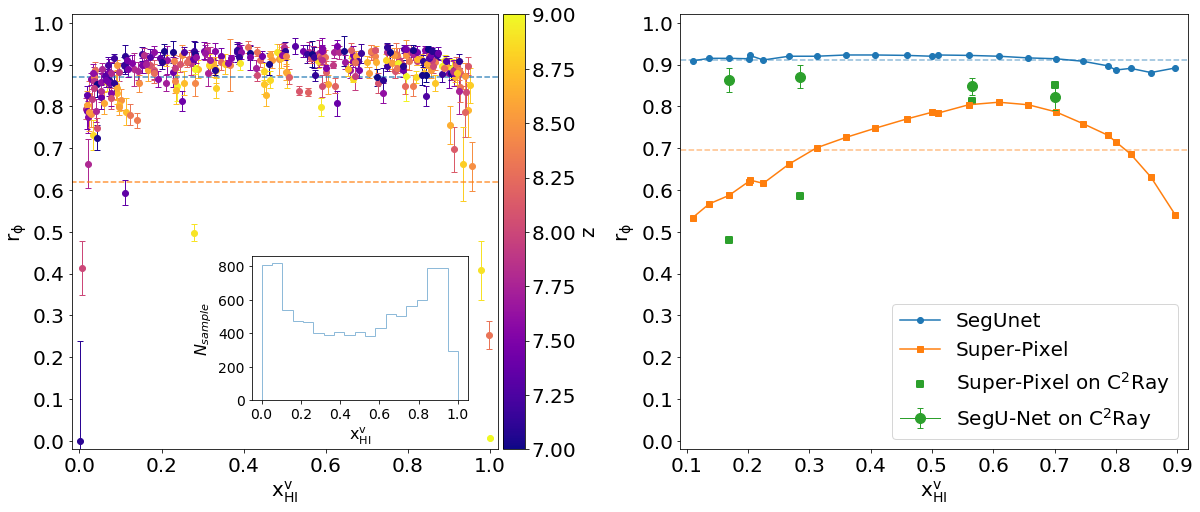

In [10]:
import matplotlib
import matplotlib.pyplot as plt, numpy as np
from myutils.utils import OrderNdimArray
from scipy.interpolate import interp1d, splev, splrep, UnivariateSpline

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 20

tobs = 1000
PATH_MODEL1 = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/pred_tobs%d/' %tobs
redshift, xn_sim, phicoef_seg, phicoef_seg_err, phicoef_sp, xfrac = OrderNdimArray(np.loadtxt(PATH_MODEL1+'astro_data.txt', unpack=True, usecols=(1,5,6,7,8,9)), 1)

xfrac_train = np.loadtxt('/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/astro_params.txt', usecols=(6))

print('\nRandom test simulations:')
phi_seg_low_z = np.mean(phicoef_seg[redshift <= 7.75])
phi_seg_high_z = np.mean(phicoef_seg[redshift >= 8.25])
print('r_phi_seg = %.3f' %np.mean(phicoef_seg))
print('r_phi_seg = %.3f (z<7.75)\t%.3f (z>8.25)\n' %(phi_seg_low_z, phi_seg_high_z))
phi_sp_low_z = np.mean(phicoef_sp[redshift <= 7.75])
phi_sp_high_z = np.mean(phicoef_sp[redshift >= 8.25])
print('r_phi_sp = %.3f' %np.mean(phicoef_sp))
print('r_phi_sp = %.3f (z<7.75)\t%.3f (z>8.25)' %(phi_sp_low_z, phi_sp_high_z))


fig, (ax0, ax1) = plt.subplots(ncols=2)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1.8])

cm = matplotlib.cm.plasma
sc = ax0.scatter(xfrac, phicoef_seg, c=redshift, vmin=7, vmax=9, s=25, cmap=cm, marker='.')
norm = matplotlib.colors.Normalize(vmin=7, vmax=9, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cm)
redshift_color = np.array([(mapper.to_rgba(v)) for v in redshift])
for x, y, e, clr, red in zip(xfrac, phicoef_seg, phicoef_seg_err, redshift_color, redshift):
    ax0.errorbar(x, y, e, lw=1, marker='o', capsize=3, color=clr)
ax0.set_xlim(xfrac.min()-0.02, xfrac.max()+0.02), ax0.set_xlabel(r'$\rm x^v_{HI}$', size=20)
ax0.set_ylim(-0.02, 1.02), ax0.set_ylabel(r'$\rm r_{\phi}$', size=20)
ax0.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xticks(np.arange(0, 1.1, 0.2))
ax0.hlines(y=np.mean(phicoef_seg), xmin=-0.02, xmax=1.1, ls='--', alpha=0.8, color='tab:blue')
ax0.hlines(y=np.mean(phicoef_sp), xmin=-0.02, xmax=1.1, ls='--', alpha=0.8, color='tab:orange')
fig.colorbar(sc, ax=ax0, pad=0.01, label=r'$\rm z$')


axin = plt.axes([0.25, 0.21, 0.15, 0.25])
h = axin.hist(xfrac_train, np.linspace(1e-5, 1., 20), histtype='step', color='tab:blue', alpha=0.5)
axin.set_ylabel(r'$N_{sample}$', size=16), plt.xlabel(r'$\rm x^v_{HI}$', size=16)
#axin.set_yticks(np.arange(0., 2100, 500))
axin.tick_params(axis="both", labelsize=14)
axin.set_xticks(np.arange(0, 1.1, 0.2))


#ax2 = ax0.twinx()
#ax2 = plt.subplot(gs[1], sharex=ax0)

#h = ax2.hist(xfrac_train, np.linspace(1e-5, 1., 20), histtype='step', color='tab:blue', alpha=0.5)
#h = ax2.hist(xfrac, np.linspace(1e-5, 1., 20), density=True, histtype='step', color='tab:blue', alpha=0.5)
#ax2.axes.get_yaxis().set_visible(False)

# MCC comparison
PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/fiducial_model/'
redshift, phicoef_seg, phicoef_seg_err, phicoef_sp, xfrac = OrderNdimArray(np.loadtxt('%sastro_data_FM_tobs%d.txt' %(PATH_MODEL, tobs), unpack=True, usecols=(0,1,2,3,4)), 0)

print('\nFiducial simulation:')
phi_seg_low_z = np.mean(phicoef_seg[redshift <= 7.75])
phi_seg_high_z = np.mean(phicoef_seg[redshift >= 8.25])
print('r_phi_seg = %.3f' %np.mean(phicoef_seg))
print('r_phi_seg = %.3f (z<7.75)\t%.3f (z>8.25)\n' %(phi_seg_low_z, phi_seg_high_z))
phi_sp_low_z = np.mean(phicoef_sp[redshift <= 7.75])
phi_sp_high_z = np.mean(phicoef_sp[redshift >= 8.25])
print('r_phi_sp = %.3f' %np.mean(phicoef_sp))
print('r_phi_sp = %.3f (z<7.75)\t%.3f (z>8.25)' %(phi_sp_low_z, phi_sp_high_z))

ax1.hlines(y=np.mean(phicoef_seg), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:blue')
ax1.hlines(y=np.mean(phicoef_sp), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:orange')
ax1.plot(xfrac, phicoef_seg, label='SegUnet', color='tab:blue', marker='o')
ax1.plot(xfrac, phicoef_sp, label='Super-Pixel', color='tab:orange', marker='s')


clr = 'tab:green'
ax1.errorbar(0.1690, 0.864, 0.029, lw=1, markersize=10, marker='o', capsize=3, color=clr, label=r'SegU-Net on C$\rm ^2$Ray')
ax1.scatter(0.1690, 0.481, lw=2, marker='s', color=clr, label=r'Super-Pixel on C$\rm ^2$Ray')
ax1.errorbar(0.2856, 0.871, 0.027, lw=1, markersize=10, marker='o', capsize=3, color=clr)
ax1.scatter(0.2856, 0.586, lw=2, marker='s', color=clr)
ax1.errorbar(0.5658, 0.848, 0.021, lw=1, markersize=10, marker='o', capsize=3, color=clr)
ax1.scatter(0.5658, 0.813, lw=2, marker='s', color=clr)
ax1.errorbar(0.7009, 0.823, 0.031, lw=1, markersize=10, marker='o', capsize=3, color=clr)
ax1.scatter(0.7009, 0.851, lw=2, marker='s', color=clr)


ax1.set_xlim(xfrac.min()-0.02, xfrac.max()+0.02), ax1.set_xlabel(r'$\rm x^v_{HI}$', size=20)
ax1.set_ylim(-0.02, 1.02), ax1.set_ylabel(r'$\rm r_{\phi}$', size=20)
ax1.legend(loc=4)
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_xticks(np.arange(0.1, 0.91, 0.1))
plt.savefig('%sphi_coef_tobs%d.png' %(PATH_MODEL1, tobs), bbox_inches="tight")
plt.show()

## Prediction Statistics

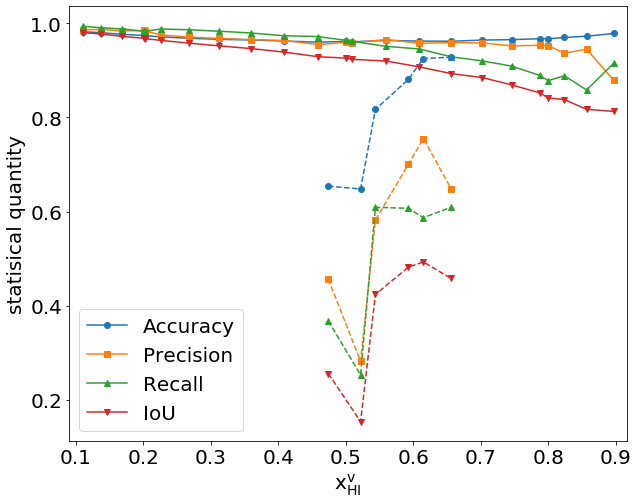

In [19]:
from myutils.utils import OrderNdimArray
tobs = 1000
PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/fiducial_model/'
redshift, acc, prec, rec, iou, xfrac, xn_seg = OrderNdimArray(np.loadtxt('%sastro_data_FM_tobs%d_stats.txt' %(PATH_MODEL, tobs), unpack=True), 5)

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 20
plt.plot(xfrac, acc, label='Accuracy', marker='o', color='tab:blue')
plt.plot(xfrac, prec, label='Precision', marker='s', color='tab:orange')
plt.plot(xfrac, rec, label='Recall', marker='^', color='tab:green')
plt.plot(xfrac, iou, label='IoU', marker='v', color='tab:red')

plt.plot([0.474, 0.522, 0.544, 0.593, 0.615, 0.656], [0.654, 0.648, 0.817, 0.881, 0.925, 0.928], 'o--', color='tab:blue')
plt.plot([0.474, 0.522, 0.544, 0.593, 0.615, 0.656], [0.457, 0.282, 0.582, 0.701, 0.755, 0.649], 's--', color='tab:orange')
plt.plot([0.474, 0.522, 0.544, 0.593, 0.615, 0.656], [0.368, 0.253, 0.609, 0.607, 0.587, 0.609], '^--', color='tab:green')
plt.plot([0.474, 0.522, 0.544, 0.593, 0.615, 0.656], [0.256, 0.154, 0.424, 0.482, 0.493, 0.458], 'v--', color='tab:red')

plt.legend()
plt.xlim(xfrac.min()-0.02, xfrac.max()+0.02)
#plt.ylim(0.8, 1.), plt.yticks(np.arange(0.8, 1.01, 0.02))

plt.ylabel('statisical quantity', size=20), plt.xlabel(r'$\rm x^v_{HI}$', size=20)
#plt.savefig('%sstats_tobs%d_Liu.png' %(PATH_MODEL, tobs), bbox_inches="tight")


## Compare $r_{\phi}$ vs $x_{HI}$ for different $t_{obs}$


tbos=500
r_phi_seg = 0.889 +/- 0.020
r_phi_sp = 0.690 +/- 0.020

tbos=1000
r_phi_seg = 0.912 +/- 0.013
r_phi_sp = 0.695 +/- 0.013

tbos=1500
r_phi_seg = 0.920 +/- 0.010
r_phi_sp = 0.699 +/- 0.010


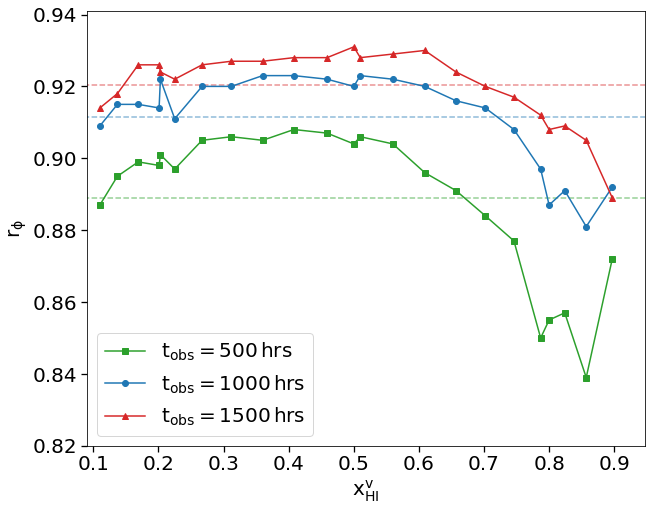

In [24]:
from myutils.utils import OrderNdimArray

time_obs = np.array([500, 1000, 1500])
colors = ['tab:green','tab:blue','tab:red']
marks = ['s', 'o', '^']
PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/fiducial_model/'

plt.figure(figsize=(10,8))
for i in range(time_obs.size):
    tobs = time_obs[i]
    clr = colors[i]
    mk = marks[i]
    
    redshift, phicoef_seg, phicoef_seg_err, phicoef_sp, xfrac = OrderNdimArray(np.loadtxt('%sastro_data_FM_tobs%d.txt' %(PATH_MODEL, tobs), unpack=True, usecols=(0,1,2,3,4)), 0)
    print('\ntbos=%d' %tobs)
    print('r_phi_seg = %.3f +/- %.3f' %(np.mean(phicoef_seg), np.std(phicoef_seg)))
    print('r_phi_sp = %.3f +/- %.3f' %(np.mean(phicoef_sp), np.std(phicoef_seg)))

    # MCC comparison
    plt.hlines(y=np.mean(phicoef_seg), xmin=0, xmax=1, ls='--', alpha=0.5, color=clr)
    plt.plot(xfrac, phicoef_seg, label=r'$\rm t_{obs}=%d\,hrs$' %tobs, color=clr, marker=mk)

plt.xlim(xfrac.min()-0.02, xfrac.max()+0.05), plt.xlabel(r'$\rm x^v_{HI}$', size=20)
plt.ylim(0.83, 0.941), plt.ylabel(r'$\rm r_{\phi}$', size=20)
plt.legend(loc=3)
plt.tick_params(length=6, width=1.3)
plt.yticks(np.arange(0.82, 0.941, 0.02))

plt.savefig('%sphi_coef_compare_tobs.png' %(PATH_MODEL+'../compare_tobs/'), bbox_inches="tight")
plt.show()

## MCC score dependency on observation time 

In [28]:
import pickle

uvfile = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/uvmap_128_z7-20.pkl'
if not (os.path.exists(uvfile)):
    print('uv-map pickle not found')
else:
    uvs = pickle.load(open(uvfile, 'rb'))

Nant = uvs['Nant']

zeta = 39.204
Rmfp = 12.861
Tvir = 4.539

params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]
c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
a_params = {'HII_EFF_FACTOR':zeta, 'R_BUBBLE_MAX':Rmfp, 'ION_Tvir_MIN':Tvir}

In [42]:
from scipy.stats import norm

tobs = np.array([200, 500, 700, 900, 1000, 1200, 1500, 2000])
redshift = np.array([7.310, 8.032, 8.720])

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/compare_tobs/'
compare_tobs = np.loadtxt('%scompare_tobs.txt' %(PATH_MODEL))
std_noise = np.zeros_like(compare_tobs)

for iz, z in enumerate(redshift):
    uv = uvs['%.3f' %z]

    for it, t in enumerate(tobs):
        noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], z, obs_time=t, boxsize=params['BOX_LEN'], total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv, N_ant=Nant, verbose=False)
        smt_noise_cube = t2c.smooth_coeval(noise_cube, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)
        mu, std = norm.fit(smt_noise_cube.flatten())
        print(mu, std)
        """
        plt.hist(smt_noise_cube.flatten(), density=True, bins=150, label='z = %.3f' %z)
        x = np.linspace(smt_noise_cube.min(), smt_noise_cube.max(), 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', label='fit')
        plt.legend()
        plt.show(), plt.clf()
        """;
        std_noise[iz, it] = std

Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 317.06it/s]


...noise cube created.
0.01714290811029482 0.9841390652315583
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 310.12it/s]


...noise cube created.
0.010090128975129977 0.6209043278641363
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 357.30it/s]


...noise cube created.
-0.010844890508162537 0.5318010302647607
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 318.10it/s]


...noise cube created.
-0.009291285006489012 0.46862041151977146
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 331.87it/s]


...noise cube created.
0.00990119537496089 0.4380640591092663
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 337.16it/s]


...noise cube created.
0.0015686074603417075 0.40278432046275453
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 255.82it/s]


...noise cube created.
-0.003154075141220545 0.3598140327174895
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 306.58it/s]


...noise cube created.
0.006403648517426986 0.3146168425475562
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 300.31it/s]


...noise cube created.
-0.017673869071109394 1.0795607171817134
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 304.29it/s]


...noise cube created.
0.012038846457866563 0.6672812631277518
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 329.68it/s]


...noise cube created.
0.004409274701066868 0.5640332315915276
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 337.57it/s]


...noise cube created.
-0.0012872272482224033 0.5018430927641098
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 317.69it/s]


...noise cube created.
-0.009106080921923762 0.4787665351753659
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 306.36it/s]


...noise cube created.
-0.014571579764038261 0.4307402933197657
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 226.71it/s]


...noise cube created.
0.0033777907632430502 0.38760812576401815
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 238.25it/s]


...noise cube created.
0.006729723457863135 0.33710012566479297
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 301.39it/s]


...noise cube created.
-0.019724414806939105 1.3336488020200608
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 310.30it/s]


...noise cube created.
-0.027413874808969504 0.8421612312619255
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 298.56it/s]


...noise cube created.
0.018453206717776588 0.7245761940260234
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 313.30it/s]


...noise cube created.
0.0049060196316219095 0.6367940707322819
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 303.36it/s]


...noise cube created.
0.016131038680987007 0.5954720015503407
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 363.51it/s]


...noise cube created.
-0.016358804346416254 0.5422851605056729
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 320.64it/s]


...noise cube created.
-0.008633087357095667 0.48271133077617395
Creating the noise cube...


100%|██████████| 128/128 [00:00<00:00, 341.64it/s]


...noise cube created.
0.0024946972611952253 0.42023352155369553


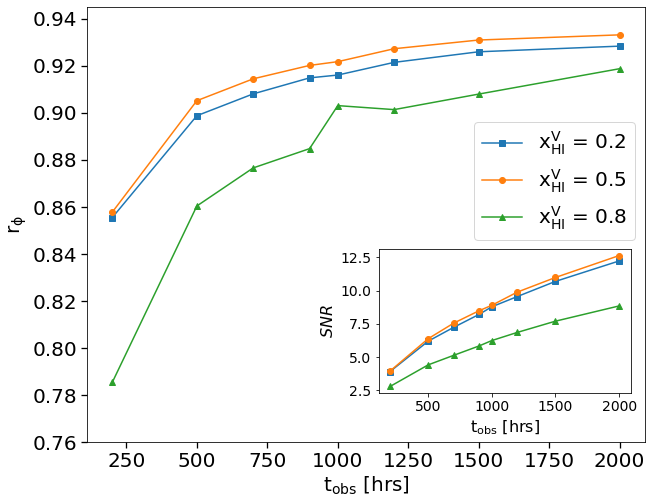

In [47]:
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 20
tobs = np.array([200, 500, 700, 900, 1000, 1200, 1500, 2000])

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/compare_tobs/'

xfrac = np.array([0.2, 0.5, 0.8])
compare_tobs = np.loadtxt('%scompare_tobs.txt' %(PATH_MODEL))
std_signal = np.loadtxt('%ssignal_std.txt' %(PATH_MODEL))
marks = ['s', 'o', '^']

for i in range(xfrac.size):
    ct_mean = compare_tobs[i]
    x_n = xfrac[i]
    mk = marks[i]
    plt.plot(tobs, ct_mean, mk+'-', label=r'$\rm x^V_{HI}$ = %.1f' %x_n)

plt.xlabel(r'$\rm t_{obs}$ [hrs]', size=20)
plt.ylim(0.775, 0.945), plt.ylabel(r'$\rm r_{\phi}$', size=20)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.6))
plt.tick_params(length=6, width=1.3)
plt.yticks(np.arange(0.76, 0.945, 0.02))

axin = plt.axes([0.53, 0.21, 0.35, 0.25])
for j in range(xfrac.size):
    sigma = std_noise[j]
    x_n = xfrac[j]
    mk = marks[j]
    axin.plot(tobs, std_signal[j]/sigma, mk+'-', label=r'$\rm x^V_{HI}$ = %.1f' %x_n)
axin.set_ylabel(r'$SNR$', size=16), plt.xlabel(r'$\rm t_{obs}$ [hrs]', size=16)
#axin.set_yticks(np.arange(0., 2100, 500))
axin.tick_params(axis="both", labelsize=14)


plt.savefig('%sphi_coef_at_tobs.png' %PATH_MODEL, bbox_inches="tight")
plt.show()

from myutils.plots import MergeImages
MergeImages('phi_coef_tobs', ['%sphi_coef_compare_tobs.png' %PATH_MODEL, '%sphi_coef_at_tobs.png' %PATH_MODEL], form='h', output_path=PATH_MODEL)

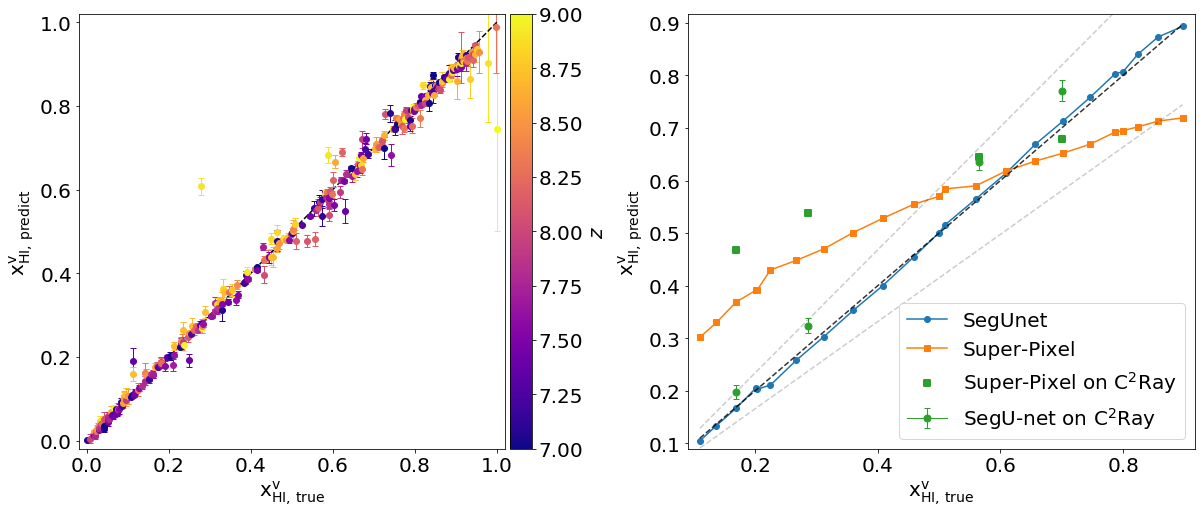

In [9]:
import matplotlib
import matplotlib.pyplot as plt, numpy as np
from myutils.utils import OrderNdimArray, RandomIndexes

tobs = 1000
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 20

PATH_MODEL1 = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/pred_tobs1000/'
redshift, xn_mask_true, xn_seg, xn_seg_err, xn_sp = OrderNdimArray(np.loadtxt(PATH_MODEL1+'astro_data.txt', unpack=True, usecols=(1,9,10,11,12)), 1)

fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.plot(xn_mask_true, xn_mask_true, 'k--')
cm = matplotlib.cm.plasma
sc = ax0.scatter(xn_mask_true, xn_seg, c=redshift, vmin=7, vmax=9, s=25, cmap=cm, marker='.')
norm = matplotlib.colors.Normalize(vmin=7, vmax=9, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
redshift_color = np.array([(mapper.to_rgba(v)) for v in redshift])
for x, y, e, clr in zip(xn_mask_true, xn_seg, xn_seg_err, redshift_color):
    ax0.errorbar(x, y, e, lw=1, marker='o', capsize=3, color=clr)
ax0.set_xlim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax0.set_xlabel(r'$\rm x^v_{HI,\,true}$', size=20)
ax0.set_ylim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax0.set_ylabel(r'$\rm x^v_{HI,\,predict}$', size=20)
fig.colorbar(sc, ax=ax0, pad=0.01, label=r'$z$')

PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/fiducial_model/'
redshift, xn_mask_true, xn_seg, xn_seg_err, xn_sp = OrderNdimArray(np.loadtxt('%sastro_data_FM_tobs%d.txt' %(PATH_MODEL, tobs), unpack=True, usecols=(0,4,5,6,7)), 1)

#ax1.hlines(y=np.mean(phicoef_seg), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:blue')
#ax1.hlines(y=np.mean(phicoef_sp), xmin=0, xmax=1, ls='--', alpha=0.5, color='tab:orange')
ax1.plot(xn_mask_true, xn_seg, 'o-', label='SegUnet', color='tab:blue', )
ax1.plot(xn_mask_true, xn_sp, 's-', label='Super-Pixel', color='tab:orange')

"""
ax1.scatter(xn_mask_true, xn_seg, color='tab:blue', marker='o', label='SegUnet')
#ax1.vlines(x=xn_mask_true, ymin=np.min([xn_seg, xn_mask_true], axis=0), ymax=np.max([xn_seg, xn_mask_true], axis=0), color='tab:blue', linewidths=0.1)
ax1.scatter(xn_mask_true, xn_sp, color='tab:orange', marker='o', label='Super-Pixel')
#ax1.vlines(x=xn_mask_true, ymin=np.min([xn_sp, xn_mask_true], axis=0), ymax=np.max([xn_sp, xn_mask_true], axis=0), color='tab:orange', linewidths=0.1)
"""
ax1.plot(xn_mask_true, xn_mask_true, 'k--', alpha=0.8)
ax1.plot(xn_mask_true, xn_mask_true*(1.+0.341/2), 'k--', alpha=0.2)
ax1.plot(xn_mask_true, xn_mask_true*(1.-0.341/2), 'k--', alpha=0.2)

clr = 'tab:green'
ax1.errorbar(0.1690, 0.1978, 0.0126, lw=1, markersize=7, marker='o', capsize=3, color=clr, label=r'SegU-net on C$\rm ^2$Ray')
ax1.errorbar(0.2856, 0.3234, 0.0142, lw=1, markersize=7, marker='o', capsize=3, color=clr)
ax1.errorbar(0.5658, 0.6350, 0.0148, lw=1, markersize=7, marker='o', capsize=3, color=clr)
ax1.errorbar(0.7009, 0.7706, 0.0197, lw=1, markersize=7, marker='o', capsize=3, color=clr)
ax1.scatter(0.1690, 0.4681, lw=2, marker='s', color=clr, label=r'Super-Pixel on C$\rm ^2$Ray')
ax1.scatter(0.2856, 0.5373, lw=2, marker='s', color=clr)
ax1.scatter(0.5658, 0.6454, lw=2, marker='s', color=clr)
ax1.scatter(0.7009, 0.6780, lw=2, marker='s', color=clr)


ax1.set_xlim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax1.set_xlabel(r'$\rm x^v_{HI,\,true}$', size=20)
ax1.set_ylim(xn_mask_true.min()-0.02, xn_mask_true.max()+0.02), ax1.set_ylabel(r'$\rm x^v_{HI,\,predict}$', size=20)
plt.legend(loc=4)
plt.savefig('%scorr_tobs%d.png' %(PATH_MODEL1, tobs), bbox_inches="tight")

## Betti numbers 

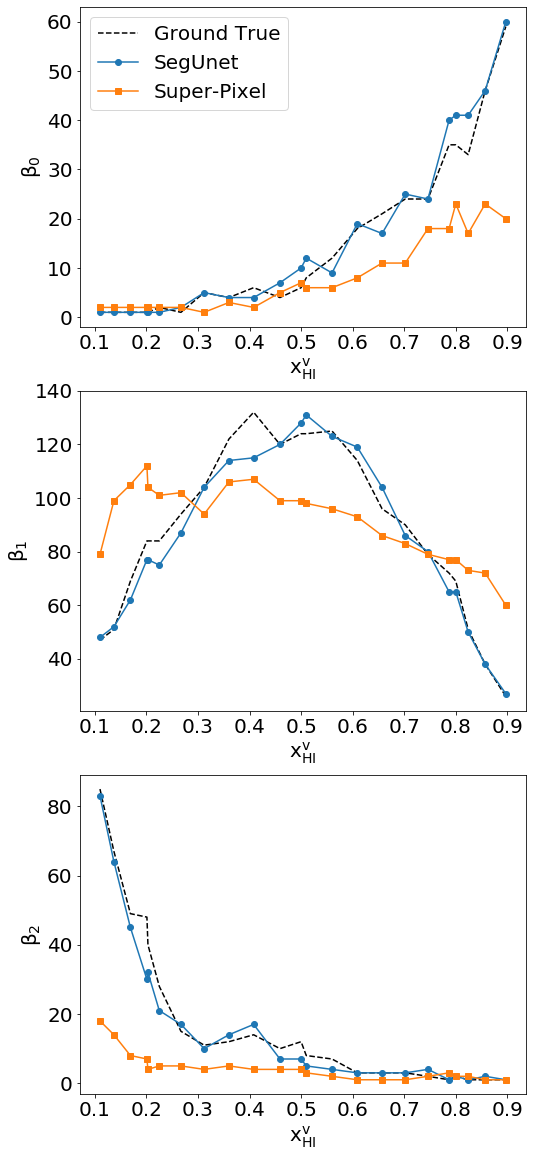

In [30]:
import matplotlib
import matplotlib.pyplot as plt, numpy as np
from myutils.utils import OrderNdimArray, RandomIndexes

plt.rcParams['font.size'] = 20

tobs = 1000
PATH_MODEL = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/fiducial_model/'
redshift, xn_mask_true, b2_true, b1_true, b0_true, b2_seg, b1_seg, b0_seg, b2_sp, b1_sp, b0_sp = OrderNdimArray(np.loadtxt('%sastro_data_FM_tobs%d.txt' %(PATH_MODEL, tobs), unpack=True, usecols=(0,4,8,9,10,11,12,13,14,15,16)), 1)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8,20))
#fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(23,5), sharex=True)

# Betti 0
ax0.plot(xn_mask_true, b0_true, 'k--', label='Ground True')
ax0.plot(xn_mask_true, b0_seg, label='SegUnet', color='tab:blue', marker='o')
ax0.plot(xn_mask_true, b0_sp, label='Super-Pixel', color='tab:orange', marker='s')
ax0.legend(loc='best')
ax0.set_xlabel(r'$\rm x^v_{HI}$', size=20), ax0.set_ylabel(r'$\rm\beta_0$', size=20)
ax0.set_xticks(np.arange(0.1, 0.91, 0.1))

# Betti 1
ax1.plot(xn_mask_true, b1_true, 'k--', label='Ground True')
ax1.plot(xn_mask_true, b1_seg, label='SegUnet', color='tab:blue', marker='o')
ax1.plot(xn_mask_true, b1_sp, label='Super-Pixel', color='tab:orange', marker='s')
ax1.set_xlabel(r'$\rm x^v_{HI}$', size=20), ax1.set_ylabel(r'$\rm\beta_1$', size=20)
ax1.set_xticks(np.arange(0.1, 0.91, 0.1))
ax1.set_yticks(np.arange(40, 150, 20))

# Betti 2
ax2.plot(xn_mask_true, b2_true, 'k--', label='Ground True')
ax2.plot(xn_mask_true, b2_seg, label='SegUnet', color='tab:blue', marker='o')
ax2.plot(xn_mask_true, b2_sp, label='Super-Pixel', color='tab:orange', marker='s')
ax2.set_xlabel(r'$\rm x^v_{HI}$', size=20), ax2.set_ylabel(r'$\rm\beta_2$', size=20)
ax2.set_xticks(np.arange(0.1, 0.91, 0.1))

plt.subplots_adjust(hspace=0.2)
plt.savefig('%sbetti_tobs%d.png' %(PATH_MODEL+'../pred_tobs'+str(tobs)+'/', tobs), bbox_inches="tight")
plt.show()

## Get intermediate layers output

## Get output of intermediate layer for Test Case

In [17]:
# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/tests/runs/'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/model-sem21cm_ep56.h5


In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tools21cm as t2c, math
import sys
from myutils.plots import MergeImages

plt.rcParams['font.size'] = 5
plt.rcParams['figure.constrained_layout.use'] = False

def VisualizeLayersOutputs(model, X, y, path='./'):
    extrm = np.max([np.abs(np.min(X)), np.max(X)])
    for i in tqdm(range(len(model.layers))):
        layer = model.layers[i]
        inter_layer_model = Model(inputs=model.input, outputs=layer.output)
        
        if(i != 0):
            inter_layer_output = inter_layer_model.predict(X)

            colmn = 16
            row = inter_layer_output.shape[3]//colmn if(inter_layer_output.shape[3]//colmn != 0) else 1

            #if(inter_layer_output.shape[-1] != 1):

            for j in range(inter_layer_output.shape[-1]):
                if(row == 8):
                    plt.figure(figsize=(7,7))
                elif(row > 8):
                    plt.figure(figsize=(5,5))
                else:
                    plt.figure(figsize=(10,10))

                plt.imshow(np.array(inter_layer_output)[0,...,j], vmin=-extrm, vmax=extrm, origin='lower', cmap='seismic', extent=[0, inter_layer_output.shape[1], 0, inter_layer_output.shape[2]])
                plt.tick_params(axis='both', which='both', length=0, width=0, labelsize=0)
                plt.margins(0, 0)
                plt.savefig('%sfoo_h%d.png' %(path, j), bbox_inches="tight")
                plt.close('all')
            
            # Merge images togheter
            if(row == 1):
                arr_old_name = ['%sfoo_h%d.png' %(path, j) for j in range(inter_layer_output.shape[-1])]
                MergeImages(new_image_name='layer%d_%s' %(i, layer.name), old_image_name=arr_old_name, output_path=path, form='h', delete_old=False)
            else:
                arr_old_name = np.array(['%sfoo_h%d.png' %(path, j) for j in range(inter_layer_output.shape[-1])]).reshape(row, colmn)
                for r in range(row):
                    MergeImages(new_image_name='foo_v%d' %r, old_image_name=arr_old_name[r], output_path=path, form='h', delete_old=False)
                
                arr_old_name = ['%sfoo_v%d.png' %(path, r) for r in range(row)]
                MergeImages(new_image_name='layer%d_%s' %(i, layer.name), old_image_name=arr_old_name, output_path=path, form='v', delete_old=False)
                
        else:
            fig = plt.figure(figsize=(15,15))
            plt.imshow(X.squeeze(), vmin=-extrm, vmax=extrm, origin='lower', cmap='seismic', extent=[0, X.shape[1], 0, X.shape[2]])
            plt.contour(y.squeeze(), colors='lime', levels=[0.5], extent=[0, X.shape[1], 0, X.shape[2]])
            plt.tick_params(axis='both', which='both', length=0, width=0, labelsize=0)
            plt.margins(0, 0)
            plt.savefig('%slayer%d_%s.png' %(path, i, layer.name), bbox_inches="tight")
            plt.close('all')
        
        #t2c.save_cbin('%slayer%d.bin' %(path, i), np.array(inter_layer_output).squeeze())
    os.system("rm %sfoo*" %path)
    return np.array(inter_layer_output)

In [20]:
path_test = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/layers_output/layer_images/'
out_seg = VisualizeLayersOutputs(model=model, X=dT3[np.newaxis,:,64,:, np.newaxis], y=mask_xn[np.newaxis,:,64,:, np.newaxis] , path=path_test)

100%|██████████| 77/77 [49:25<00:00,  7.17s/it]


## Predict sphere

In [4]:
def sphere(shape, radius, position):
    semisizes = (radius,) * 3
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    arr = np.zeros(shape, dtype=float)
    
    for x_i, semisize in zip(position, semisizes):
        arr += (x_i / semisize) ** 2

    return arr <= 1.0

def Sphere(r=50):
    data = sphere((128, 128, 128), r, (64, 64, 64))
    return data.astype(float)

def Molecule():
    data = sphere((128, 128, 128), 50, (64, 64, 64)) \
            + sphere((128, 128, 128), 30, (32, 32, 32))\
            + sphere((128, 128, 128), 30, (96, 96, 96))\
            + sphere((128, 128, 128), 30, (32, 96, 96))\
            + sphere((128, 128, 128), 30, (32, 32, 96))\
            + sphere((128, 128, 128), 30, (32, 96, 32))\
            + sphere((128, 128, 128), 30, (32, 32, 96))\
            + sphere((128, 128, 128), 30, (96, 32, 32))\
            + sphere((128, 128, 128), 30, (96, 32, 96))\
            + sphere((128, 128, 128), 30, (96, 96, 32))
    return data.astype(float)

def SwissCheese(rs=[10,20], nrb=50):
    data = sphere((128, 128, 128), 5, (64, 64, 14))
    for i in range(nrb):
        radius = np.random.uniform(rs[0], rs[1])
        center = np.random.uniform(0, 128, size=3)
        data += sphere((128, 128, 128), radius, center)
    return data.astype(float)

def ManWithHat():
    hat = np.zeros((128, 128, 128))
    for i in range(128):
        for j in range(128):
            for k in range(128):
                if((i>=35 and i <= 40) and (j>=42 and j<=80) and (k>=17 and k<=64)):
                    hat[i,j,k] = 1
    data = sphere((128, 128, 128), 40, (75, 64, 64)) \
            + sphere((128, 128, 128), 18, (32, 60, 64)) \
            + sphere((128, 128, 128), 15, (64, 64, 94)) \
            + hat

    return data.astype(float)

def RescaleData(arr, a=-1, b=1):
    scaled_arr = (arr.astype(np.float32) - np.min(arr))/(np.max(arr) - np.min(arr)) * (b-a) + a
    return scaled_arr


x_n = 0.128	 z = 8.032
dT_mean=-0.000	dT_min=-6.689	dT_max=15.704


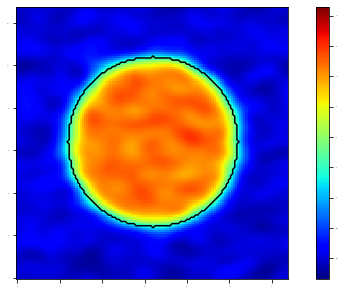

(None, None)

<Figure size 720x360 with 0 Axes>

In [22]:
data = Sphere(r=40)
#data = Molecule()
#data = SwissCheese(rs=[15,30], nrb=30)
#data = ManWithHat()
print('x_n = %.3f\t z = %.3f' %(np.mean(data), z))

dT_test = RescaleData(data, a=-8, b=8)
dT_test = t2c.subtract_mean_signal(dT_test, los_axis=2)
dT_test_smt = t2c.smooth_coeval(dT_test+noise_cube, z, box_size_mpc=cube.user_params.HII_DIM, max_baseline=2.0, ratio=1.0, nu_axis=2)

print('dT_mean=%.3f\tdT_min=%.3f\tdT_max=%.3f' %(np.mean(dT_test_smt), np.min(dT_test_smt), np.max(dT_test_smt)))

# Plot
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(dT_test_smt[:,:,64], cmap='jet', origin='lower', vmin=np.min(dT_test_smt), vmax=np.max(dT_test_smt))
plt.colorbar()
plt.contour(data[:,:,64], colors='k', levels=[0.5])
plt.savefig(outpath+'sphere_slice.png', bbox_inches='tight')

plt.show(), plt.clf()

In [17]:
PowerSpectrum??

In [90]:
path_test  = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions_1/test_predict/layer_test2/'
out_seg = VisualizeLayersOutputs(model=model, X=dT_test_smt.astype(dtype='float64')[np.newaxis,:,64,:, np.newaxis], y=data.astype(int)[np.newaxis,:,64,:, np.newaxis] , path=path_test)

100%|██████████| 77/77 [50:41<00:00,  7.62s/it]


## Prediction Test

In [16]:
y = data.astype(int)

conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/tests/runs/net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

from utils_network.prediction import SegUnet21cmPredict
from utils.other_utils import RescaleData

X_tta = SegUnet21cmPredict(unet=model, x=dT_test_smt, TTA=False)
X_seg = np.round(np.mean(X_tta, axis=0))

  0%|          | 0/1 [00:00<?, ?it/s]

 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/model-sem21cm_ep56.h5


100%|██████████| 1/1 [00:24<00:00, 24.73s/it]


In [18]:
# Super-Pixel
labels = t2c.slic_cube(dT_test_smt.astype(dtype='float64'), n_segments=50000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(dT_test_smt, labels)
X_sp = 1-t2c.stitch_superpixels(dT_test_smt, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 72061 segments


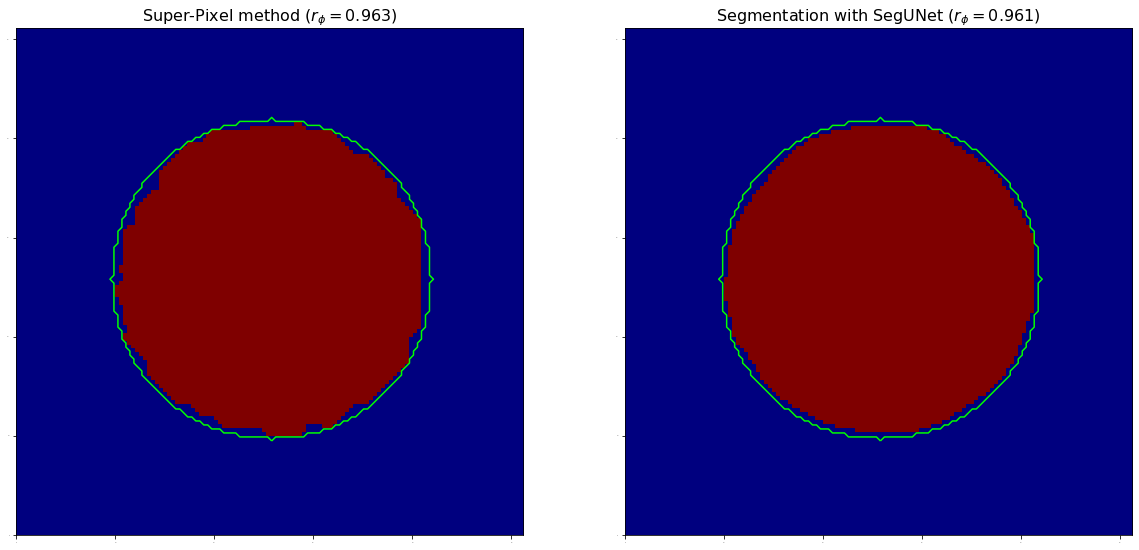

<Figure size 1440x720 with 0 Axes>

In [21]:
from sklearn.metrics import matthews_corrcoef

outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/test_sphere/'
phicoef_seg = matthews_corrcoef(y.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(y.flatten(), X_sp.flatten())

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 0

idx = params['HII_DIM']//2
#idx = 10
ls=16
plt.subplot(121)
plt.title('Super-Pixel method ($r_{\phi}=%.3f$)' %phicoef_sp, size=ls)
plt.imshow(X_sp[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,:,idx], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'Segmentation with SegUNet ($r_{\phi}=%.3f$)' %phicoef_seg, size=ls)
plt.imshow(X_seg[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,:,idx], colors='lime', levels=[0.5], extent=my_ext)
plt.savefig(outpath+'test_visual_comparison.png', bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]

idx = params['HII_DIM']//2

X_seg_err = np.std(X_tta, axis=0)

fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2, sharey=True, sharex=True)

#ax1.set_title('SegU-Net ($r_{\phi}=%.3f$)' %phicoef_seg, size=ls)
ax1.imshow(X_seg[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
ax1.contour(y[:,:,idx], colors='lime', levels=[0.5], extent=my_ext)
ax1.set_xlabel('x [Mpc]')

ax2.set_title('SegUNet Pixel-Error', size=ls)
im = plt.imshow(X_seg_err[:,:,idx], origin='lower', cmap='jet', extent=my_ext)
fig.colorbar(im, label=r'$\sigma_{std}$', ax=ax2, pad=0.02, cax=fig.add_axes([0.905, 0.25, 0.02, 0.51]))
ax2.set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in [ax0,ax1]: ax.label_outer()

plt.savefig('%svisual_comparison%s.png' %(outpath, name), bbox_inches='tight')

plt.show()
plt.clf()

## prediction with $T_S$
create simulation box with spin temperature

In [3]:
z = 8.939
zeta = 65.204
Rmfp = 11.861
Tvir = 4.539
LX = 35

params = {'HII_DIM':128, 'DIM':384, 'BOX_LEN':256}
c_params = {'OMm':0.27, 'OMb':0.046, 'SIGMA_8':0.82, 'POWER_INDEX':0.96}
a_params = {'HII_EFF_FACTOR':zeta, 'R_BUBBLE_MAX':Rmfp, 'ION_Tvir_MIN':Tvir, 'L_X':LX}
my_ext = [0, params['BOX_LEN'], 0, params['BOX_LEN']]

ic = p21c.initial_conditions(user_params=params, cosmo_params=c_params, random_seed=2020)
pert_field = p21c.perturb_field(redshift=z, init_boxes=ic)
T_S = p21c.spin_temperature(perturbed_field=pert_field, astro_params=a_params, zprime_step_factor=1.05)
ionized_box = p21c.ionize_box(spin_temp=T_S, zprime_step_factor=1.05, z_heat_max=20.0)
cubeS = p21c.brightness_temperature(ionized_box=ionized_box, perturbed_field=pert_field, spin_temp=T_S)

print(' z = %.3f\t xn = %.3f' %(z, np.mean(ionized_box.xH_box)))

outpath = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/predictions/spin_test/'

 z = 8.939	 xn = 0.504


In [4]:
dT = cubeS.brightness_temp
xH = ionized_box.xH_box   # x_HI

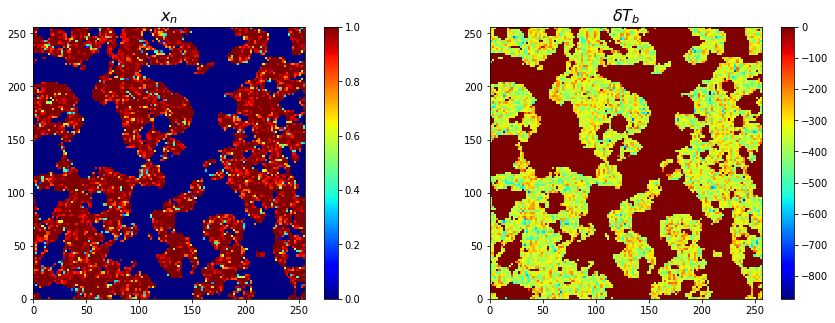

In [5]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.subplot(121)
plt.title('$x_n$', size=16)
plt.imshow(xH[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
#plt.contour(mask_xn[:,params['HII_DIM']//2,:], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'$\delta T_b$', size=16)
plt.imshow(dT[:,params['HII_DIM']//2,:], origin='lower', cmap='jet', extent=my_ext, interpolation='nearest')
plt.colorbar()
plt.savefig(outpath+'dTb_Ts.png', bbox_inches='tight')

In [6]:
smt_xn = t2c.smooth_coeval(xH, cubeS.redshift, box_size_mpc=cubeS.user_params.HII_DIM, max_baseline=2.0, ratio=1.0, nu_axis=2)
mask_xn = smt_xn > 0.5

In [7]:
# run onece (t~6-7min)
PATH_UV = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/'
if(os.path.exists(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z)) and os.path.exists(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))):
    uv = np.load(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z))
    Nant = np.load(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))
else:
    uv, Nant = t2c.get_uv_daily_observation(params['HII_DIM'], z,
                                        filename=None,      # If None, it uses the SKA-Low 2016 configuration.
                                        total_int_time=6.0, # Observation per day in hours.
                                        int_time=10.0,      # Time period of recording the data in seconds.
                                        boxsize=cparams['BOX_LEN'], declination=-30.0, verbose=False)

    np.save(PATH_UV+'uv_coverage_%d/uvmap_z%.3f.npy' %(params['HII_DIM'], z))
    np.save(PATH_UV+'uv_coverage_%d/Nantmap_z%.3f.npy' %(params['HII_DIM'], z))
    
#t = 1000
tobs = 1000

np.random.seed(seed)
noise_cube = t2c.noise_cube_coeval(params['HII_DIM'], z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=tobs, filename=None, boxsize=params['BOX_LEN'],
                                   total_int_time=6.0, int_time=10.0, declination=-30.0, uv_map=uv,
                                   N_ant=Nant, verbose=True, fft_wrap=False)


dT1 = t2c.subtract_mean_signal(dT, los_axis=2)
dT2 = dT1 + noise_cube

# Smooth the data to resolution corresponding to maximum baseline of 2 km
dT3 = t2c.smooth_coeval(dT2, z, box_size_mpc=params['HII_DIM'], max_baseline=2.0, ratio=1.0, nu_axis=2)
print('...done')


Creating the noise cube...
...done


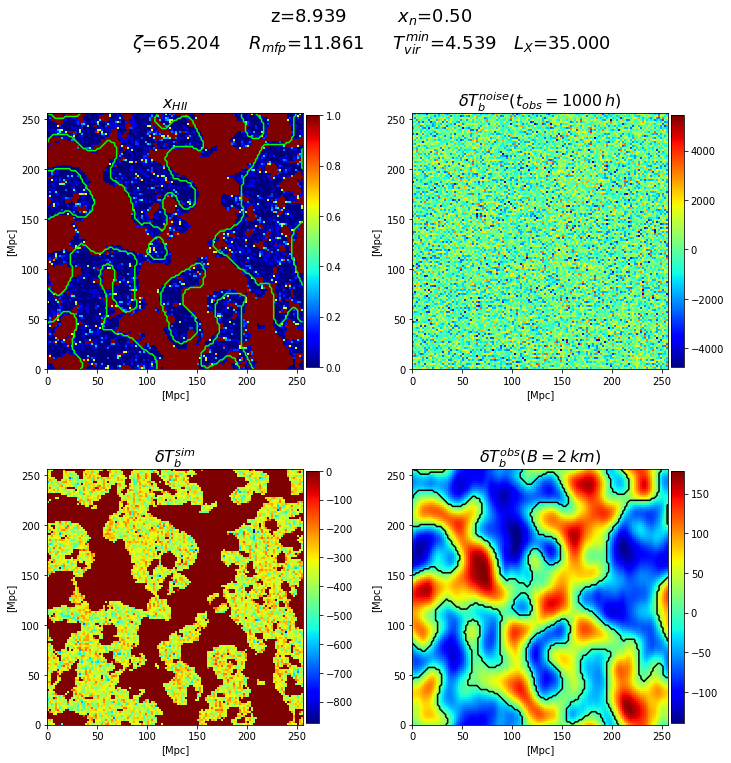

In [18]:
idx = 64

fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('z=%.3f\t\t$x_n$=%.2f\n$\zeta$=%.3f     $R_{mfp}$=%.3f     $T_{vir}^{min}$=%.3f   $L_{X}$=%.3f' %(z, np.mean(ionized_box.xH_box), zeta, Rmfp, Tvir, LX), fontsize=18)

axs[0,0].set_title('$x_{HII}$', size=16)
axs[0,0].contour(mask_xn[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
im = axs[0,0].imshow(1-xH[:,idx,:], origin='lower', cmap='jet', extent=my_ext, vmin=0, vmax=1)
axs[0,0].set_xlabel('[Mpc]'), axs[0,0].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[0,0], pad=0.01, shrink=0.85)

axs[0,1].set_title('$\delta T^{noise}_b(t_{obs}=%d\,h)$' %tobs, size=16)
im = axs[0,1].imshow(dT2[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[0,1].set_xlabel('[Mpc]'), axs[0,1].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[0,1], pad=0.01, shrink=0.85)

axs[1,0].set_title('$\delta T^{sim}_b$', size=16)
im = axs[1,0].imshow(dT[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,0].set_xlabel('[Mpc]'), axs[1,0].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[1,0], pad=0.01, shrink=0.85)

axs[1,1].set_title('$\delta T^{obs}_b(B=2\,km)$', size=16)
im = axs[1,1].imshow(dT3[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
axs[1,1].contour(mask_xn[:,idx,:], colors='k', levels=[0.5], extent=my_ext)
axs[1,1].set_xlabel('[Mpc]'), axs[1,1].set_ylabel('[Mpc]');
fig.colorbar(im, ax=axs[1,1], pad=0.01, shrink=0.85)

plt.savefig(outpath+'cube21cm_Ts.png', bbox_inches='tight')

In [9]:
print(dT3.mean(), dT3.min(), dT3.max())

-0.011086416977279592 -159.78264812783806 182.29552076569868


In [10]:
from tensorflow.keras.models import load_model
from utils_network.metrics import iou, iou_loss, dice_coef, dice_coef_loss, balanced_cross_entropy, phi_coef
from config.net_config import NetworkConfig

def LoadSegUnetModel(cfile):
    avail_metrics = {'binary_accuracy':'binary_accuracy', 'iou':iou, 'dice_coef':dice_coef, 'iou_loss':iou_loss, 'dice_coef_loss':dice_coef_loss, 'phi_coef':phi_coef, 'mse':'mse', 'mae':'mae', 'binary_crossentropy':'binary_crossentropy', 'balanced_cross_entropy':balanced_cross_entropy}
    conf = NetworkConfig(conf_file)

    INPATH = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_061020/tobs1000/'
    PATH_OUT = conf.resume_path
    MODEL_EPOCH = conf.best_epoch
    METRICS = [avail_metrics[m] for m in np.append(conf.loss, conf.metrics)]
    cb = {func.__name__:func for func in METRICS if not isinstance(func, str)}
    model_loaded = load_model('%smodel-sem21cm_ep%d.h5' %(PATH_OUT+'checkpoints/', MODEL_EPOCH), custom_objects=cb)
    
    print(' Loaded model:\n %s' %(conf.resume_path))
    return model_loaded


# load model
conf_file = '/home/michele/Documents/PhD_Sussex/output/ML/SegNet/config/runs/'
conf_file += 'net2D_021020.ini'
model = LoadSegUnetModel(conf_file)

Using TensorFlow backend.


 Loaded model:
 /home/michele/Documents/PhD_Sussex/output/ML/dataset/outputs/new/02-10T23-52-36_128slice/


In [11]:
X = dT3[np.newaxis, ..., np.newaxis]
y = mask_xn.astype(int)

# SegUnet 2D
X1 = np.empty_like(dT3)
X2 = np.empty_like(dT3)
X3 = np.empty_like(dT3)
for i in tqdm(range(params['HII_DIM'])):
    X1[i,:,:] = model.predict(X[:,i,:,:,:], verbose=0).squeeze()  
    X2[:,i,:] = model.predict(X[:,:,i,:,:], verbose=0).squeeze()
    X3[:,:,i] = model.predict(X[:,:,:,i,:], verbose=0).squeeze()
X_seg = np.round((X1 + X2 + X3)/3.).astype(int)


100%|██████████| 128/128 [00:36<00:00,  2.67it/s]


In [12]:
# Super-Pixel
X = X.squeeze()
labels = t2c.slic_cube(X.astype(dtype='float64'), n_segments=5000, compactness=0.1, max_iter=20, sigma=0, min_size_factor=0.5, max_size_factor=3, cmap=None)
superpixel_map = t2c.superpixel_map(X, labels)
X_sp = 1-t2c.stitch_superpixels(X, labels, bins='knuth', binary=True, on_superpixel_map=True)

The output contains the labels created by SLIC with 5827 segments


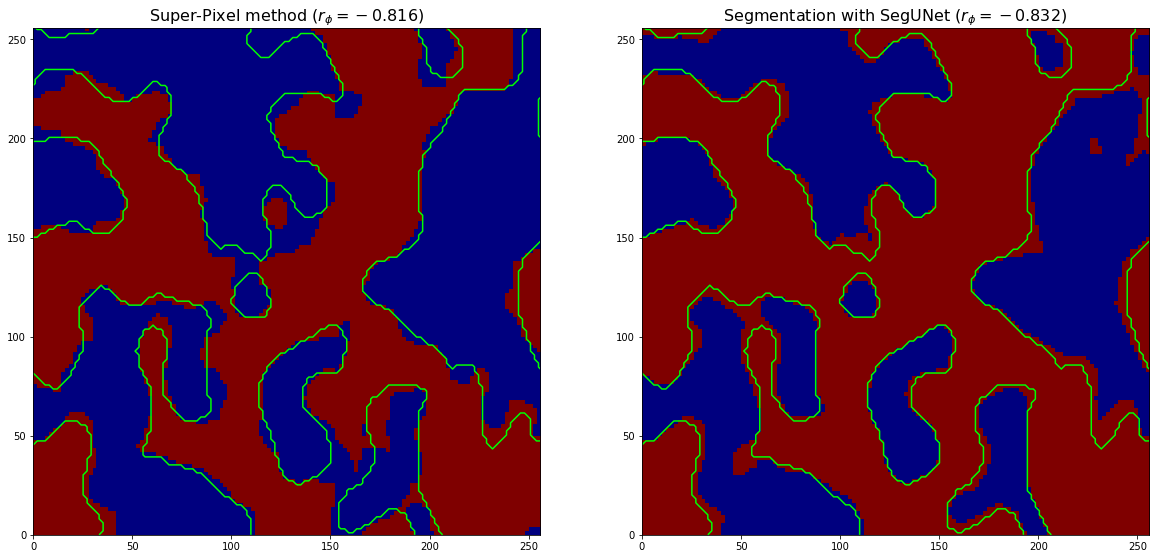

<Figure size 1440x720 with 0 Axes>

In [13]:
from sklearn.metrics import matthews_corrcoef

phicoef_seg = matthews_corrcoef(y.flatten(), X_seg.flatten())
phicoef_sp = matthews_corrcoef(y.flatten(), X_sp.flatten())

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['figure.figsize'] = [20, 10]

idx = params['HII_DIM']//2

plt.subplot(121)
plt.title('Super-Pixel method ($r_{\phi}=%.3f$)' %phicoef_sp, size=16)
plt.imshow(X_sp[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.subplot(122)
plt.title(r'Segmentation with SegUNet ($r_{\phi}=%.3f$)' %phicoef_seg, size=16)
plt.imshow(X_seg[:,idx,:], origin='lower', cmap='jet', extent=my_ext)
plt.contour(y[:,idx,:], colors='lime', levels=[0.5], extent=my_ext)
plt.savefig(outpath+'test_visual_comparison_Ts.png', bbox_inches='tight')
plt.show()
plt.clf()

In [65]:
import zipfile
import numpy as np
from glob import glob
from tqdm import tqdm
import tools21cm as t2c

PATH_INPUT = '/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/'

astr_param = np.loadtxt(PATH_INPUT+'astro_params.txt')

xn_mask_train = np.zeros(10000)

for idx in tqdm(range(xn_mask_train.size)):
    z, xn = astr_param[idx,1], astr_param[idx,5]
    for i in range(1, 13):
        var = '%sdata3D_128_030920_part%d.zip' %(PATH_INPUT, i)

        content = np.loadtxt(PATH_INPUT+'content_part%d.txt' %i, dtype=int)
        if(idx in content):
            print(dirname, content)

            with zipfile.ZipFile(var, 'r') as myzip:
                f = myzip.extract(member='%s/data/xH_21cm_i%d.bin' %(var[var[:-5].rfind('/')+1:-4], idx), path=PATH_INPUT)
                xH = t2c.read_cbin(f)
                assert '%.3f' %np.mean(xH) == str(xn)
                smt_xn = t2c.smooth_coeval(xH, z, box_size_mpc=128, max_baseline=2.0, ratio=1.0, nu_axis=2)
                mask_xn = smt_xn>0.5
                xn_mask_train[idx] = np.mean(mask_xn)
                os.system('rm -r %s/' %var[:-4])  
                break

    new_astr_data = np.vstack((astr_param.T, xn_mask_train)).T

    t1 = '# HII_EFF_FACTOR: The ionizing efficiency of high-z galaxies\n'
    t2 = '# R_BUBBLE_MAX: Mean free path in Mpc of ionizing photons within ionizing regions\n'
    t3 = '# ION_Tvir_MIN: Minimum virial Temperature of star-forming haloes in log10 units\n'
    t4 = '#i\tz\teff_f\tRmfp\tTvir\tsim x_n\tmask x_n'
    np.savetxt('astro_params.txt', new_astr_data, header=t1+t2+t3+t4, fmt='%d\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f')


/home/michele/Documents/PhD_Sussex/output/ML/dataset/inputs/data3D_128_030920/data3D_128_030920_part1.zip [   0    1    2 ... 6788 6789 6790]


In [67]:
assert '%.3f' %(0.5) == str(0.5), print('eerr')

eerr


AssertionError: None